In [5]:
from DataProcessing import Data

# 1. Get Data

## 1.1. Get data from folder

In [6]:
d = Data()
d.get_index_names()
chosen_index = 'AAPL'
d.preprocess(chosen_index)
df = d.get_data(chosen_index)
df= df.drop(['Date', 'Volume'],axis=1)
df.columns

S&P 500: ['AAPL', 'ORCL', 'GOOGL', 'AMZN', 'BK', 'LIFE', 'T', 'XOM']
 VN: ['VHM', 'CTR', 'FPT', 'MBB']
Processing AAPL.csv
Saved AAPL data at data/processed/AAPL.csv


Index(['High', 'Low', 'Close', 'RSI', 'MFI', 'EMA', 'SO', 'MACD',
       'Next Day Price'],
      dtype='object')

In [7]:
INPUT_SHAPE=8
X = df[df.columns[0:INPUT_SHAPE]].values
Y = df[df.columns[INPUT_SHAPE]].values

TRAIN_PERCENT = 0.7
train_size = int(TRAIN_PERCENT*len(X))

X_train = X[0:train_size]
Y_train = Y[0:train_size]
X_test = X[train_size:len(X)]
Y_test = Y[train_size:len(Y)]

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Train model

In [9]:
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [10]:
class Individual:
    def __init__(self,position = [0,0,0], velocity = [0,0,0], cognitive_coef=1, social_coef=1):
        self.cognitive_coef = cognitive_coef
        self.social_coef = social_coef
        self.position = position
        self.velocity = velocity
        self.model:SVR = SVR(kernel='sigmoid',gamma=self.position[0],coef0=self.position[1],epsilon=self.position[2],C=150)
        self.best_position = position
        self.fitness = self.compute_fitness(self.model)

    def compute_fitness(self,model:SVR):
        model.fit(X_train_scaled,Y_train)
        return -mean_squared_error(Y_train,model.predict(X_train_scaled))
    
    def update_indi_best(self, new_position):
        new_model:SVR = SVR(kernel='sigmoid',gamma=new_position[0],coef0=new_position[1],epsilon=new_position[2])
        new_model_fitness = self.compute_fitness(new_model)
        if(new_model_fitness>=self.fitness):
            self.best_position = new_position
            self.model = new_model
        return self.best_position
    
    def update_velocity(self, best_pos_in_pop):
        for i in range(len(self.position)):
            r = np.random.uniform(0,1,2)
            self.velocity[i] = self.velocity[i] + self.cognitive_coef*r[0]*(self.best_position[i] - self.position[i]) + self.social_coef*r[1]*(best_pos_in_pop[i] - self.position[i])
        return self.velocity
    
    def update_position(self):
        new_pos = np.zeros(len(self.position))
        for i in range(len(self.position)):
            if(i==1):
                new_pos[i] = self.velocity[i] + self.position[i]
            else:
                new_pos[i] = abs(self.velocity[i] + self.position[i])
        self.update_indi_best(new_pos)
        self.position = new_pos
        return new_pos

In [11]:
class Population:
    def __init__(self, pop_size, cognitive_coef, social_coef):
        self.pop_size = pop_size
        gamma = np.random.uniform(0,0.01,pop_size)
        coef0 = np.random.uniform(-0.1,0.1,pop_size)
        epsilon = np.random.uniform(0,0.1,pop_size)
        self.pop = []
        for i in range(pop_size):
            indi = Individual(position=[gamma[i],coef0[i],epsilon[i]],cognitive_coef=cognitive_coef, social_coef=social_coef)
            self.pop.append(indi)
        self.cognitive_coef = cognitive_coef
        self.social_coef = social_coef

    def new_Individual(self,individual:Individual)->Individual:
        return Individual(individual.position, individual.velocity, individual.cognitive_coef, individual.social_coef)
    
    def get_best_individual(self)->Individual:
        self.pop = sorted(self.pop,key=lambda x:x.fitness)
        best_individual:Individual = self.new_Individual(self.pop[-1])
        return best_individual

    def update_population(self):
        best_particle:Individual = self.get_best_individual()
        for i in range(self.pop_size):
            temp = self.new_Individual(self.pop[i])
            temp.update_velocity(best_particle.position)
            temp.update_position()
            temp.compute_fitness(temp.model)
            if(temp.fitness>self.pop[i].fitness):
                self.pop[i] = temp
            if(temp.fitness>best_particle.fitness):
                best_particle = temp
        
        return

## 2.1. Train

In [12]:
population_size = 100
cognitive_coef = 1
social_coef = 1
number_of_generation = 10

In [13]:
population = Population(population_size,cognitive_coef,social_coef)
fitness = []
moving_avg_fitness = []
EPSILON = 0.01

for i in range(number_of_generation):
    population.update_population()
    best_individual = population.get_best_individual()
    fitness.append(best_individual.fitness)
    # if(i<100):
    #     moving_avg_fitness.append(fitness[i])
    # else:
    #     moving_avg_fitness.append(np.mean(fitness[i-99:i+1]))
    #     if(abs(moving_avg_fitness[i]-moving_avg_fitness[i-1])/moving_avg_fitness[i]<EPSILON):
    #         break
    percentage = i/number_of_generation*100
    print(f'PSO: {percentage}%')
        

PSO: 0.0%
PSO: 10.0%
PSO: 20.0%
PSO: 30.0%
PSO: 40.0%
PSO: 50.0%
PSO: 60.0%
PSO: 70.0%
PSO: 80.0%
PSO: 90.0%


In [14]:
population.get_best_individual().fitness

-5.770355339131691

In [15]:
model = population.get_best_individual().model
model

SVR(C=150, coef0=-0.04667080949939411, epsilon=0.08878012066010935,
    gamma=0.0058906993881009066, kernel='sigmoid')

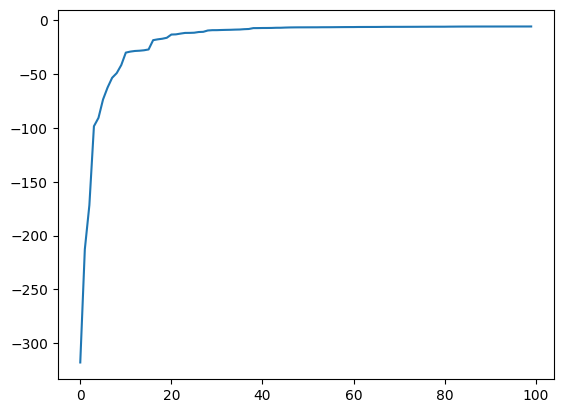

In [16]:
import matplotlib.pyplot as plt
f = []
for indi in population.pop:
    f.append(indi.fitness)
plt.plot(f)

## 2.2. Test

In [ ]:
model = population.get_best_individual().model
model

In [18]:
Y_pred = model.predict(X_test_scaled)

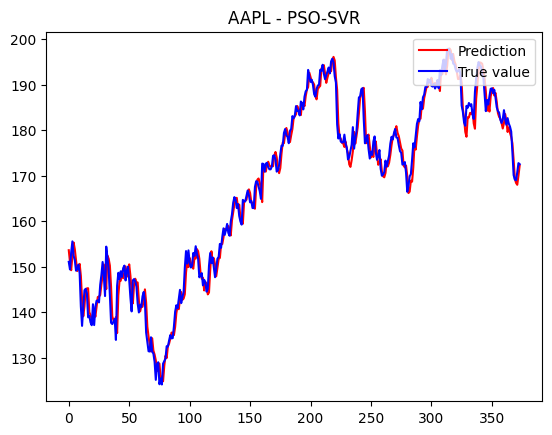

In [19]:
import matplotlib.pyplot as plt
plt.plot(Y_pred,c='red',label = 'Prediction')
plt.plot(Y_test,c='blue',label = 'True value')
plt.legend(loc='upper right')
plt.title(f'{chosen_index} - PSO-SVR')
plt.show()

In [20]:
X_train_scaled[0:5]

array([[-1.56818298, -1.56158594, -1.55911337,  0.58212821,  0.92319854,
        -1.55923348, -0.03368867, -1.55496649],
       [-1.55223625, -1.54589757, -1.54297729,  0.70151029,  0.88435979,
        -1.55453888,  0.43205954, -1.54989953],
       [-1.54053423, -1.53355826, -1.53525732,  0.66162882,  0.89102869,
        -1.54943997,  0.6773902 , -1.54603613],
       [-1.54128005, -1.53361706, -1.53328393,  0.53199623,  0.77587496,
        -1.54475757,  0.72717975, -1.54296234],
       [-1.53709259, -1.51722358, -1.52568025,  0.49123873,  0.73197311,
        -1.53968476,  1.05480337, -1.53901266]])

In [21]:
X_train[0:5]

array([[46.13252801, 45.33830438, 46.02663422, 67.26842912, 64.27090925,
        45.23706993, 61.53847172, 44.63221053],
       [46.80160287, 45.98090127, 46.69570541, 69.30064657, 63.76177347,
        45.43155466, 75.74346645, 44.84232462],
       [47.29258257, 46.48632078, 47.01580811, 68.62175228, 63.84919585,
        45.64278845, 83.22588   , 45.00253013],
       [47.2612904 , 46.48391213, 47.09763336, 66.41504243, 62.33964972,
        45.83676778, 84.74442625, 45.12999231],
       [47.43698321, 47.15539059, 47.41291428, 65.72123554, 61.76414195,
        46.04692064, 94.7367177 , 45.2937758 ]])